# Import

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import (
    firwin,
    butter, buttord,
    cheby1, cheb1ord,
    cheby2, cheb2ord,
    ellip, ellipord,
    lfilter,
    freqz, sosfreqz,
    resample,
    tf2zpk,
 )

from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple, Union
import soundfile as sf
import pandas as pd
from scipy.io import wavfile
import math

from flopoco_fixiir_metrics import coeffs_to_flopoco_hex_list, run_fixiir_and_parse_metrics

In [17]:
fs = 24000 # fréquence d'échantillonnage
bands = np.arange(22, 40)   # bande 22 → 36 (car fu < fs/2)

In [23]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


## Verification standard + guess ordre du filtre

In [19]:
def verify_ansi_standard(
    taps_or_b,
    fl,
    fu,
    fs,
    delta_rel=0.05,
    a=None,
    ripple_db=1.0,
    att_db=60.0
):
    """
    Vérification ANSI S1.11 simplifiée et cohérente FPGA.

    Vérifie :
      - ripple passband ±ripple_db
      - atténuation ≥ att_db hors ±1/3 octave
      - stabilité IIR si applicable

    Supporte :
      - FIR : taps_or_b = taps, a=None
      - IIR BA : taps_or_b=b, a=a
      - IIR SOS : taps_or_b = sos (n_sections, 6), a=None
    """

    ripple_pp_max = 2.0 * ripple_db * (1.0 + delta_rel)
    att_min = att_db * (1.0 - delta_rel)

    f_lo = fl / (2 ** (1 / 3))
    f_hi = fu * (2 ** (1 / 3))

    w = np.linspace(0, fs / 2, 8192, endpoint=False)[1:]

    stable_ok = True

    if a is None and isinstance(taps_or_b, np.ndarray) and taps_or_b.ndim == 2:
        w, h = sosfreqz(taps_or_b, worN=w, fs=fs)
        for sec in taps_or_b:
            if np.any(np.abs(np.roots(sec[3:])) >= 1):
                stable_ok = False
                break
    else:
        if a is None:
            w, h = freqz(taps_or_b, worN=w, fs=fs)
        else:
            w, h = freqz(taps_or_b, a, worN=w, fs=fs)
            stable_ok = np.all(np.abs(np.roots(a)) < 1)

    H_db = 20 * np.log10(np.maximum(np.abs(h), 1e-12))

    f0 = math.sqrt(fl * fu)
    H_db -= H_db[np.argmin(np.abs(w - f0))]

    passband = (w >= fl) & (w <= fu)
    stopband = (w < f_lo) | (w > f_hi)

    ripple_pp = H_db[passband].max() - H_db[passband].min()
    att_stop = -H_db[stopband].max()

    return {
        "ripple_pp_db": float(ripple_pp),
        "att_stop_db": float(att_stop),
        "stable": bool(stable_ok),
        "valid": bool(
            ripple_pp <= ripple_pp_max
            and att_stop >= att_min
            and stable_ok
        ),
        "spec_ripple_pp_max_db": ripple_pp_max,
        "spec_att_min_db": att_min,
    }


In [20]:
wl = 53
delta_rel = 0.05
ripple_db = 1.0
att_db = 60.0

data = []
invalid_filters = []

def check_iir_stability(b, a):
    poles = np.roots(a)
    max_abs_pole = np.max(np.abs(poles))
    return poles, max_abs_pole

iir_types = ['butterworth', 'chebyshev1', 'chebyshev2', 'elliptic']

for iir_type in iir_types:
    for band in bands:
        fl, f0, fu = ansi_band(band)

        # --- Spécifications de design ---
        wp = np.array([fl, fu]) / (fs / 2)
        ws = np.array([fl / (2 ** (1 / 3)), fu * (2 ** (1 / 3))]) / (fs / 2)

        gpass = ripple_db
        gstop = att_db

        # --- Estimation ordre + design ---
        if iir_type == 'butterworth':
            N, Wn = buttord(wp, ws, gpass, gstop)
            b, a = butter(N, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev1':
            N, Wn = cheb1ord(wp, ws, gpass, gstop)
            b, a = cheby1(N, gpass, Wn, btype='bandpass', output='ba')
        elif iir_type == 'chebyshev2':
            N, Wn = cheb2ord(wp, ws, gpass, gstop)
            b, a = cheby2(N, gstop, Wn, btype='bandpass', output='ba')
        elif iir_type == 'elliptic':
            N, Wn = ellipord(wp, ws, gpass, gstop)
            new_N = N+2
            b, a = ellip(new_N, gpass, gstop, Wn, btype='bandpass', output='ba')
        else:
            raise ValueError("Type IIR inconnu")

        effective_order = len(a) - 1

        # --- Bits entiers nécessaires ---
        max_coeff = max(np.max(np.abs(b)), np.max(np.abs(a)))
        ib = max(2, math.ceil(math.log2(max_coeff)) + 1)
        frac_bits = wl - ib
        scale = 2 ** frac_bits

        # --- Quantification ---
        b_q = quantize(b, wl, integer_bits=ib)
        a_q = quantize(a, wl, integer_bits=ib)
        a_q[0] = 1.0
        
        # --- Test de stabilité (pôles du filtre quantifié) ---
        _, max_abs_pole = check_iir_stability(b_q, a_q)
        stable = bool(max_abs_pole < 1.0)


        # --- Vérification ANSI ---
        result_5 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.05,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_10 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.10,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_15 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.15,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )
        result_20 = verify_ansi_standard(
            b_q, fl, fu, fs,
            delta_rel=0.20,
            a=a_q,
            ripple_db=ripple_db,
            att_db=att_db
        )

        octave = (band - 22) // 3 + 1
        filter_nb = (band - 22) % 3 + 1

        # --- Coefficients b ---
        for i, coeff in enumerate(b_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'b', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),     
                bin(fixed),
                result_5["valid"],
                result_10["valid"],
                result_15["valid"],
                result_20["valid"]
            ])

        # --- Coefficients a ---
        for i, coeff in enumerate(a_q):
            fixed = int(np.round(coeff * scale))
            data.append([
                iir_type, band, octave, filter_nb,
                N, effective_order,
                'a', i,
                ib, frac_bits,
                float(coeff),
                coeff.hex(),    
                bin(fixed),
                result_5["valid"],
                result_10["valid"],
                result_15["valid"],
                result_20["valid"]
            ])

df = pd.DataFrame(
    data,
    columns=[
        'iir_type', 'band', 'octave', 'filter_nb',
        'iir_order_N', 'iir_order_effective',
        'coeff_type', 'coeff_index',
        'integer_bits', 'frac_bits',
        'quantized_value',
        'float_hex',         
        'binary_repr',
        'ansi_valid_5',
        'ansi_valid_10',
        'ansi_valid_15',
        'ansi_valid_20'
    ]
)

df.to_csv('auto_iir_coefficients_53bits_all_types.csv', index=False)
print("CSV généré : auto_iir_coefficients_53bits_all_types.csv")

CSV généré : auto_iir_coefficients_53bits_all_types.csv


## Légende du CSV des coefficients IIR quantifiés

- **iir_type** : Type de filtre IIR ('butterworth', 'chebyshev1', 'chebyshev2', 'elliptic')
- **band** : Bande ANSI (22 → 36)
- **octave** : Numéro de l'octave (groupes de 3 bandes 1/3 octave, octave 1 = bandes 22-24, etc.)
- **filter_nb** : Numéro du filtre dans l'octave (1, 2 ou 3)
- **iir_order_N** : Ordre prototype retourné par SciPy (N). Pour un bandpass, l'ordre effectif vaut `2*N`.
- **iir_order_effective** : Ordre effectif du filtre bandpass (= 2*N)
- **coeff_type** : Type de coefficient ('b' pour feedforward/numérateur, 'a' pour feedback/dénominateur)
- **coeff_index** : Index du coefficient dans la section (0..2 pour b0..b2 ou a0..a2)
- **integer_bits** : Bits entiers (signé) utilisés pour quantifier cette section
- **frac_bits** : Bits fractionnaires (= wl - integer_bits)
- **quantized_value** : Valeur flottante quantifiée (celle qui sera représentée en fixe)
- **binary_repr** : `bin(fixed)` (entier signé Python, utile pour debug)
- **float_hex** : Représentation hexadécimale “flottante” Python (`float.hex()`)
- **ansi_valid** : Booléen indiquant si le filtre respecte le masque (±1 dB passband, >=18 dB transition, >=60 dB deep stop + stabilité)

In [21]:
def guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type='chebyshev1'):
    """
    Utilise directement la fonction ord appropriée pour obtenir l'ordre minimal IIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        iir_type : type de filtre IIR
    
    Returns:
        int : ordre minimal IIR pour respecter les specs avec marge
    """
    
    # Définition des bandes passante et d'arrêt avec marges relatives pour la stabilité
    # Passband légèrement élargie pour garantir le ripple/atténuation
    # Stopband légèrement rétrécie pour l'atténuation/ripple
    wp = [fl * (1 + delta_rel), fu * (1 - delta_rel)]
    ws = [fl * (1 - delta_rel), fu * (1 + delta_rel)]

    # Normalisation des fréquences
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1 * (1 + delta_rel)    # atténuation max < 1 dB avec marge dans la bande passante
    gstop = 60 * (1 - delta_rel)   # atténuation min > 60 dB avec marge dans la bande d'arrêt

    if iir_type == 'butterworth':
        N, Wn = buttord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev1':
        N, Wn = cheb1ord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev2':
        N, Wn = cheb2ord(wp, ws, gpass, gstop)
    elif iir_type == 'elliptic':
        N, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    return N

In [22]:
@dataclass(frozen=True) #juste car class EllipticSimPoint n'a pas d'arguments
class EllipticSimPoint:
    """
    On créer une structure de données pour stocker un point de simulation elliptic.
    Chaque point correspond à un couple (ordre N, delta_rel) qui respecte les critères ANSI et de stabilité,
    et contient aussi le nombre minimal de bits de quantification trouvé ;)
    """
    band: int
    fl: float
    fu: float
    N: int
    effective_order: int
    delta_rel: float
    delta_pct: float
    wl_min: int
    integer_bits: int
    frac_bits: int


def _as_list(x: Union[int, Iterable[int]]) -> List[int]:
    """
    Vraiment la fonction pratique ;)
    Convertit un entier ou un itérable d'entiers en liste d'entiers.
    Permet d'accepter aussi bien une bande unique qu'une liste de bandes
    """
    if isinstance(x, int):
        return [x]
    return list(x)


def design_elliptic_bandpass(
    fl: float,
    fu: float,
    fs: float,
    N: int,
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    use_ord_Wn: bool = True,
    ws_factor: float = 2 ** (1 / 3),
    ) -> Tuple[np.ndarray, np.ndarray]:
    
    """
    On construit un filtre elliptique passe-bande (IIR) d'ordre N pour une bande [fl, fu]
    - fl, fu : bornes de la bande passante (Hz)
    - fs : fréquence d'échantillonnage (Hz)
    - N : ordre du filtre (prototype)
    - ripple_db : ondulation max en bande passante (dB)
    - att_db : atténuation min en bande d'arrêt (dB)
    - use_ord_Wn : si True, utilise ellipord pour recalculer Wn (fréquences de coupure normalisées) à partir des specs, sinon Wn=wp (Wp : fréquences de coupure de la pass band)
    - ws_factor : facteur pour définir la bande d'arrêt autour de la bande passante (Ws : fréquences stop band)
    Retourne (b, a) : coefficients du filtre (numérateur, dénominateur)
    """
    
    wp = np.array([fl, fu]) / (fs / 2)
    ws = np.array([fl / ws_factor, fu * ws_factor]) / (fs / 2)
    gpass = ripple_db
    gstop = att_db

    if use_ord_Wn:
        _Nmin, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        Wn = wp

    b, a = ellip(N, gpass, gstop, Wn, btype='bandpass', output='ba')
    return b, a


def iir_integer_bits_needed(b: np.ndarray, a: np.ndarray) -> int:
    """
    Calcule le nombre minimal de bits entiers nécessaires pour coder les coefficients IIR (b et a)
    En gros on prend le max absolu de tous les coefficients, puis log2 + 1 (bit de signe).
    """
    max_iir_coeff = max(float(np.max(np.abs(b))), float(np.max(np.abs(a))))
    if max_iir_coeff == 0:
        return 1
    return int(math.ceil(math.log2(max_iir_coeff)) + 1)


def check_iir_stability_ba(a: np.ndarray) -> Tuple[np.ndarray, float, bool]:
    """
    Vérifie la stabilité d'un filtre IIR
    Retourne les pôles, le module max, et un booléen (True si tous les pôles sont dans le cercle unité)
    """
    poles = np.roots(a)
    max_abs_pole = float(np.max(np.abs(poles))) if poles.size else 0.0
    return poles, max_abs_pole, bool(max_abs_pole < 1.0)


def quantize_iir_ba(
    b: np.ndarray,
    a: np.ndarray,
    wl: int,
    integer_bits: int,
    wrap: bool = False,
) -> Tuple[np.ndarray, np.ndarray, int]:
    
    """
    Quantifie les coefficients b et a d'un filtre IIR en virgule fixe (Qm.n).
    - wl : nombre total de bits (word length)
    - integer_bits : bits pour la partie entière (avec signe)
    - wrap : wrap-around (pas utile ici, on préfère la saturation)
    Retourne (b_q, a_q, frac_bits) : coefficients quantifiés et nb de bits fractionnaires
    """
    if wl <= integer_bits:
        raise ValueError("wl doit être > integer_bits")
    b_q = quantize(b, wl, integer_bits=integer_bits, wrap=wrap)
    a_q = quantize(a, wl, integer_bits=integer_bits, wrap=wrap)
    a_q = np.array(a_q, dtype=float)
    a_q[0] = 1.0
    frac_bits = wl - integer_bits
    return np.array(b_q, dtype=float), a_q, frac_bits


def find_min_word_length_for_valid_elliptic(
    fl: float,
    fu: float,
    fs: float,
    N: int,
    delta_rel: float,
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    wrap: bool = False,
    use_ord_Wn: bool = True,
) -> Optional[Tuple[int, int, int]]:
    """
    Pour un ordre N et un delta_rel donné, on cherche le plus petit word length (<= wl_max)
    qui permet d'obtenir un filtre stable ET qui passe la vérification ANSI
    Retourne (wl_min, integer_bits, frac_bits) ou None si aucun ne passe
    """
    b, a = design_elliptic_bandpass(
        fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn
    )
    integer_bits = max(2, iir_integer_bits_needed(b, a))
    wl_start = max(integer_bits + 1, 2)

    for wl in range(wl_start, wl_max + 1):
        b_q, a_q, frac_bits = quantize_iir_ba(b, a, wl=wl, integer_bits=integer_bits, wrap=wrap)
        _poles, _max_abs, stable = check_iir_stability_ba(a_q)
        if not stable:
            continue
        res = verify_ansi_standard(
            b_q, fl, fu, fs, delta_rel=delta_rel, a=a_q, ripple_db=ripple_db, att_db=att_db
        )
        if res["valid"]:
            return wl, integer_bits, frac_bits

    return None


def elliptic_simulate_band(
    band: int,
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
) -> Tuple[int, int, List[EllipticSimPoint]]:
    """
    Simule tous les couples (N, delta_rel) pour une bande ANSI donnée
    Cherche le plus petit N (N_min) pour lequel au moins un delta_rel passe (stabilité+ANSI)
    Puis simule pour tous les N dans [N_min, N_min+N_min/2] et tous les delta_rel donnés
    Retourne (N_min, N_end, liste des points valides).
    """
    fl, _f0, fu = ansi_band(band)
    delta_list = list(delta_list)

    N_min: Optional[int] = None
    for N in range(1, N_search_max + 1):
        ok_any = False
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn
            )
            if out is not None:
                ok_any = True
                break
        if ok_any:
            N_min = N
            break

    if N_min is None:
        return 0, 0, []

    N_end = int(N_min + (N_min // 2))
    points: List[EllipticSimPoint] = []

    for N in range(N_min, N_end + 1):
        b, a = design_elliptic_bandpass(
            fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn
        )
        eff_order = int(len(a) - 1)
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn
            )
            if out is None:
                continue
            wl_min, integer_bits, frac_bits = out
            points.append(
                EllipticSimPoint(
                    band=int(band),
                    fl=float(fl),
                    fu=float(fu),
                    N=int(N),
                    effective_order=int(eff_order),
                    delta_rel=float(d),
                    delta_pct=float(d * 100.0),
                    wl_min=int(wl_min),
                    integer_bits=int(integer_bits),
                    frac_bits=int(frac_bits),
                )
            )

    return int(N_min), int(N_end), points

In [23]:
def plot_elliptic_simulation(
    bands_to_plot: Union[int, Iterable[int]],
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
    title: Optional[str] = None,
    *,
    include_flopoco: bool = True,
    flopoco_exe: Optional[str] = None,
    ) -> Tuple[Dict[int, Tuple[int, int]], List[EllipticSimPoint]]:
    """
    Plot delta_rel% (y) vs ordre N (x) pour une ou plusieurs bandes.
    Les points sont annotés par `wl_min/lsbExt/H` ou `wl_min->wl_used/lsbExt/H*` si wl augmenté.
    """
    import os
    # fallback path if not provided
    flopoco_exe = flopoco_exe or os.path.expanduser('~/Bureau/Developpement/flopoco/build/flopoco')
    bands_list = _as_list(bands_to_plot)
    delta_list = list(delta_list)
    ranges: Dict[int, Tuple[int, int]] = {}
    all_points: List[EllipticSimPoint] = []
    for band in bands_list:
        N_min, N_end, pts = elliptic_simulate_band(
            band=int(band), fs=fs, delta_list=delta_list, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn, N_search_max=N_search_max, include_flopoco=include_flopoco, flopoco_exe=flopoco_exe,
        )
        ranges[int(band)] = (int(N_min), int(N_end))
        all_points.extend(pts)
    if not all_points:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.set_xlabel("Ordre prototype N")
        ax.set_ylabel("delta_rel (%)")
        ax.set_title(title or "Elliptic simulation (aucun point valide)")
        ax.grid(True, which='both', alpha=0.3)
        plt.show()
        return ranges, all_points
    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = plt.get_cmap('tab10')
    band_to_color = {b: cmap(i % 10) for i, b in enumerate(bands_list)}
    for band in bands_list:
        pts_b = [p for p in all_points if p.band == int(band)]
        if not pts_b:
            continue
        xs = [p.N for p in pts_b]
        ys = [p.delta_pct for p in pts_b]
        ax.scatter(xs, ys, s=30, alpha=0.9, color=band_to_color[int(band)], label=f"Bande {int(band)}")
        # Collect points where wl was increased to overplot star markers
        inc_x, inc_y = [], []
        for p in pts_b:
            lsb_txt = str(p.lsbExt) if p.lsbExt is not None else "?"
            H_txt = f"{p.H:.6g}" if p.H is not None else "?"
            star = '*' if (p.increased_bits and p.increased_bits > 0) else ''
            if p.increased_bits and p.increased_bits > 0:
                annot = f"{p.wl_min}->{p.wl_used}/{lsb_txt}/{H_txt}{star}"
            else:
                wl_display = p.wl_used if (p.wl_used is not None and p.wl_used != p.wl_min) else p.wl_min
                annot = f"{wl_display}/{lsb_txt}/{H_txt}{star}"
            ax.annotate(annot, (p.N, p.delta_pct), textcoords="offset points", xytext=(4, 4), fontsize=7, color=band_to_color[int(band)], alpha=0.9,)
            if p.increased_bits and p.increased_bits > 0:
                inc_x.append(p.N); inc_y.append(p.delta_pct)
        if inc_x:
            ax.scatter(inc_x, inc_y, marker='*', s=100, color=band_to_color[int(band)], edgecolors='k', zorder=5)
    mins = [v[0] for v in ranges.values() if v[0] > 0]
    maxs = [v[1] for v in ranges.values() if v[1] > 0]
    if mins and maxs:
        ax.set_xlim(min(mins) - 0.5, max(maxs) + 0.5)
    ax.set_yticks([d * 100.0 for d in delta_list])
    ax.set_xlabel("Ordre prototype N")
    ax.set_ylabel("delta_rel (%)")
    ax.set_title(title or "Elliptic: delta_rel% vs ordre (annotation = wl_min/lsbExt/H)")
    ax.grid(True, which='both', alpha=0.3)
    ax.legend()
    plt.show()
    return ranges, all_points

In [24]:
# Ajout: workflow: quantifié -> si échec log -> test flottant -> si flottant ok augmenter WL jusqu'à X% (configurable).

FLOPOCO_EXE = "/home/maxime/Bureau/Developpement/flopoco/build/flopoco"  
PERCENT_INCREASE_DEFAULT = 0.10  # fraction de wl_min a essayer en plus si échec
FLOPOCO_TIMEOUT_S = None  # None = pas de timeout (peut être long si FixIIR génère du VHDL)

@dataclass(frozen=True)
class EllipticSimPoint:
    band: int
    fl: float
    fu: float
    N: int
    effective_order: int
    delta_rel: float
    delta_pct: float
    wl_min: int
    integer_bits: int
    frac_bits: int
    lsbExt: Optional[int] = None
    H: Optional[float] = None
    wl_used: Optional[int] = None
    increased_bits: int = 0
    flopoco_log: Optional[str] = None

def _shorten_flopoco_error(e: Exception, max_lines: int = 10) -> str:
    msg = str(e)
    if "Log:" in msg:
        head = msg.split("Log:", 1)[0].strip()
        log = msg.split("Log:", 1)[1]
        log_lines = [ln for ln in log.splitlines() if ln.strip()]
        log_preview = "\n".join(log_lines[:max_lines])
        hint = ""
        if "Could not compute WCPG" in msg or "could not compute the WCPG" in msg:
            hint = (
                "\nHint: WCPG (libwcpg) échoue souvent quand le filtre est "
                "très marginalement stable (pôles proches de |z|=1) et que la "
                "procédure de certification ne peut pas garantir |lambda|<1."
            )
        return head + "\nLog preview:\n" + log_preview + hint
    return msg

def flopoco_fixiir_metrics_from_ba(
    b_q: np.ndarray,
    a_q: np.ndarray,
    *,
    frac_bits: int,
    flopoco_exe: str = FLOPOCO_EXE,
    verbose: bool = False,
    ) -> Tuple[Optional[float], Optional[int], Optional[str], Optional[str]]:
    """Retourne (H, lsbExt, used, err).
    Tente plusieurs conventions internes. Si verbose=True, imprime les hex envoyés.

    Note: si FloPoCo timeoute mais a déjà imprimé H/lsbExt, le wrapper Python
    les récupère quand même (timedOut=True) et on les affiche normalement.
    """
    a_tail = a_q[1:]
    trials = [
        ("a[1:]", a_tail, -12, -12),
        ("a[1:]", a_tail, -int(frac_bits), -int(frac_bits)),
        ("-a[1:]", -a_tail, -12, -12),
        ("-a[1:]", -a_tail, -int(frac_bits), -int(frac_bits)),
    ]
    errors: List[str] = []
    for (a_name, a_arr, lsbIn, lsbOut) in trials:
        coeffb = coeffs_to_flopoco_hex_list(b_q)
        coeffa = coeffs_to_flopoco_hex_list(a_arr)  # déjà sans a0
        used = f"coeffa={a_name}, lsbIn/lsbOut={lsbIn}/{lsbOut}"
        if verbose:
            print(f"[FloPoCo TRY] {used}")
            print("  coeffb (hex):", coeffb)
            print("  coeffa (hex):", coeffa)
        try:
            m = run_fixiir_and_parse_metrics(
                coeffb=coeffb,
                coeffa=coeffa,
                lsbIn=lsbIn,
                lsbOut=lsbOut,
                loglevel=1,
                generateFigures=0,
                flopoco_exe=flopoco_exe,
                timeout_s=FLOPOCO_TIMEOUT_S,
            )
            return float(m.H), int(m.lsbExt), used + (" (timeout)" if getattr(m, "timedOut", False) else ""), None
        except Exception as e:
            errors.append(f"--- {used} ---\n{_shorten_flopoco_error(e)}")
    summary = "\n\n".join(errors[:2])
    if len(errors) > 2:
        summary += f"\n\n(+{len(errors) - 2} autres essais échoués)"
    return None, None, None, summary

def elliptic_simulate_band(
    band: int,
    fs: float,
    delta_list: Iterable[float] = (0.00, 0.05, 0.10, 0.15, 0.20),
    ripple_db: float = 1.0,
    att_db: float = 60.0,
    wl_max: int = 53,
    use_ord_Wn: bool = True,
    N_search_max: int = 80,
    *,
    include_flopoco: bool = True,
    flopoco_exe: str = FLOPOCO_EXE,
    percent_increase: float = PERCENT_INCREASE_DEFAULT,
    ) -> Tuple[int, int, List[EllipticSimPoint]]:
    
    """
    Simule pour une bande ANSI donnée tous les couples (N, delta_rel) pertinents et cherche
    le plus petit ordre prototype N_min pour lequel au moins une configuration quantifiée (wl) passe
    la vérification ANSI et est stable. Pour chaque point valide, retourne les informations de quantification
    et (optionnellement) des métriques issues de FloPoCo (H, lsbExt).
    
    Paramètres
    ----------
    band : int
        Numéro de bande ANSI (ex : 30 → 1 kHz).
    fs : float
        Fréquence d'échantillonnage en Hz.
    delta_list : Iterable[float], optional
        Liste des marges relatives testées (ex. 0.0, 0.05, ...).
    ripple_db : float, optional
        Ondulation admissible en bande passante (dB).
    att_db : float, optional
        Atténuation minimale en bande d'arrêt (dB).
    wl_max : int, optional
        Word length maximal testé pour la quantification.
    use_ord_Wn : bool, optional
        Si True, utilise `ellipord` pour recalculer Wn; sinon Wn = wp.
    N_search_max : int, optional
        Ordre prototype maximal à rechercher pour N_min.
    include_flopoco : bool, optional
        Si True, exécute FloPoCo (FixIIR) pour récupérer `H` et `lsbExt` quand possible.
    flopoco_exe : str, optional
        Chemin vers l'exécutable flopoco utilisé pour FixIIR.
    percent_increase : float, optional
        Fraction de `wl_min` à essayer en plus (wl_min + extra) si la quantification initiale échoue
        mais la version flottante passe; permet de trouver un wl quantifié tolérable.
    
    Retour
    ------
    Tuple[int, int, List[EllipticSimPoint]]
        (N_min, N_end, points) où `points` est une liste d'`EllipticSimPoint` contenant les
        métadonnées de chaque point valide (wl_min, integer_bits, frac_bits, H, lsbExt, wl_used, ...).
    
    Effets de bord
    -------------
        - Si `include_flopoco` est True, cette fonction lance des processus externes (FloPoCo) qui peuvent
          prendre un temps significatif (FLOPOCO_TIMEOUT_S contrôlant le timeout global).
        - Les logs et erreurs FloPoCo sont capturés et stockés dans `EllipticSimPoint.flopoco_log`.
    """
    fl, _f0, fu = ansi_band(band)
    delta_list = list(delta_list)
    N_min: Optional[int] = None
    for N in range(1, N_search_max + 1):
        ok_any = False
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn,
            )
            if out is not None:
                ok_any = True
                break
        if ok_any:
            N_min = N
            break
    if N_min is None:
        return 0, 0, []
    N_end = int(N_min + (N_min // 2))
    points: List[EllipticSimPoint] = []
    for N in range(N_min, N_end + 1):
        b_f, a_f = design_elliptic_bandpass(
            fl=fl, fu=fu, fs=fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=use_ord_Wn,
        )
        eff_order = int(len(a_f) - 1)
        for d in delta_list:
            out = find_min_word_length_for_valid_elliptic(
                fl, fu, fs, N=N, delta_rel=d, ripple_db=ripple_db, att_db=att_db, wl_max=wl_max, use_ord_Wn=use_ord_Wn,
            )
            if out is None:
                continue
            wl_min, integer_bits, frac_bits = out
            # Reconstruit le filtre quantifié correspondant AU point (N,d)
            b_q, a_q, _ = quantize_iir_ba(
                b_f, a_f, wl=int(wl_min), integer_bits=int(integer_bits), wrap=False,
            )
            H = None
            lsbExt = None
            wl_used = int(wl_min)
            increased = 0
            flopoco_log = None
            if include_flopoco:
                # 1) Essai normal (coeff quantifié tel quel)
                print(f"[FloPoCo] band={band} N={N} d={d} try quantized wl={wl_min}")
                coeffb_hex = coeffs_to_flopoco_hex_list(b_q)
                coeffa_hex = coeffs_to_flopoco_hex_list(a_q[1:])
                print("  quantized coeffb hex:", coeffb_hex)
                print("  quantized coeffa hex:", coeffa_hex)
                H, lsbExt, used, err = flopoco_fixiir_metrics_from_ba(
                    b_q, a_q, frac_bits=int(frac_bits), flopoco_exe=flopoco_exe, verbose=False
                )
                if err is None and H is not None and lsbExt is not None:
                    wl_used = int(wl_min)
                    flopoco_log = used
                else:
                    # Log erreur et tester version flottante non-quantifiée
                    print(f"[FloPoCo ERROR initial] band={band} N={N} d={d} wl={wl_min} -> {err}")
                    print("[FloPoCo] Essai avec coefficients flottants (non quantifiés)")
                    try:
                        coeffb_fhex = coeffs_to_flopoco_hex_list(b_f)
                        coeffa_fhex = coeffs_to_flopoco_hex_list(a_f[1:])
                        print("  float coeffb hex:", coeffb_fhex)
                        print("  float coeffa hex:", coeffa_fhex)
                        # Essai direct avec lsbIn/lsbOut = -12 (heuristique)
                        m = run_fixiir_and_parse_metrics(
                            coeffb=coeffb_fhex,
                            coeffa=coeffa_fhex,
                            lsbIn=-12,
                            lsbOut=-12,
                            loglevel=1,
                            generateFigures=0,
                            flopoco_exe=flopoco_exe,
                            timeout_s=FLOPOCO_TIMEOUT_S,
                        )
                        Hf = float(m.H); lsbExtf = int(m.lsbExt)
                        print(f"[FloPoCo FLOAT OK] H={Hf} lsbExt={lsbExtf}" + (" (timeout)" if getattr(m, "timedOut", False) else ""))
                        # Si float OK, on cherche un quantifié avec plus de bits
                        max_extra = max(1, int(math.ceil(wl_min * percent_increase)))
                        success=False
                        for extra in range(1, max_extra+1):
                            wl_try = int(wl_min + extra)
                            try:
                                b_q_try, a_q_try, frac_bits_try = quantize_iir_ba(b_f, a_f, wl=wl_try, integer_bits=int(integer_bits), wrap=False)
                            except Exception:
                                continue
                            print(f"  Trying increased wl={wl_try}")
                            H2, lsbExt2, used2, err2 = flopoco_fixiir_metrics_from_ba(
                                b_q_try, a_q_try, frac_bits=int(frac_bits_try), flopoco_exe=flopoco_exe, verbose=False
                            )
                            if err2 is None and H2 is not None and lsbExt2 is not None:
                                print(f"  Success with wl={wl_try}: H={H2} lsbExt={lsbExt2}")
                                H, lsbExt, used, err = H2, lsbExt2, used2, None
                                b_q, a_q = b_q_try, a_q_try
                                wl_used = wl_try
                                increased = extra
                                flopoco_log = f"float_ok_then_found_wl_{wl_try}"
                                success=True
                                break
                        if not success:
                            # On garde les metrics float comme info mais on signale qu'on n'a pas trouvé de quantifié meilleur
                            H = Hf; lsbExt = lsbExtf; flopoco_log = "float_ok_but_no_quantized_found"; wl_used = wl_min
                    except Exception as e_float:
                        print(f"[FloPoCo FLOAT ERROR] {str(e_float)}")
                        flopoco_log = _shorten_flopoco_error(e_float)
            points.append(
                EllipticSimPoint(
                    band=int(band),
                    fl=float(fl),
                    fu=float(fu),
                    N=int(N),
                    effective_order=int(eff_order),
                    delta_rel=float(d),
                    delta_pct=float(d*100.0),
                    wl_min=int(wl_min),
                    integer_bits=int(integer_bits),
                    frac_bits=int(frac_bits),
                    lsbExt=lsbExt,
                    H=H,
                    wl_used=wl_used,
                    increased_bits=int(increased),
                    flopoco_log=flopoco_log,
                )
            )
    return int(N_min), int(N_end), points

[FloPoCo] band=37 N=4 d=0.05 try quantized wl=18
  quantized coeffb hex: 0x1.f000000000000p-10:-0x1.4800000000000p-9:0x1.1800000000000p-8:-0x1.2400000000000p-8:0x1.8c00000000000p-8:-0x1.2400000000000p-8:0x1.1800000000000p-8:-0x1.4800000000000p-9:0x1.f000000000000p-10
  quantized coeffa hex: -0x1.da24000000000p+0:0x1.3a62000000000p+2:-0x1.5e90000000000p+2:0x1.dc15000000000p+2:-0x1.462c000000000p+2:0x1.103c000000000p+2:-0x1.7d80000000000p+0:0x1.7f50000000000p-1
[FloPoCo] band=37 N=4 d=0.1 try quantized wl=18
  quantized coeffb hex: 0x1.f000000000000p-10:-0x1.4800000000000p-9:0x1.1800000000000p-8:-0x1.2400000000000p-8:0x1.8c00000000000p-8:-0x1.2400000000000p-8:0x1.1800000000000p-8:-0x1.4800000000000p-9:0x1.f000000000000p-10
  quantized coeffa hex: -0x1.da24000000000p+0:0x1.3a62000000000p+2:-0x1.5e90000000000p+2:0x1.dc15000000000p+2:-0x1.462c000000000p+2:0x1.103c000000000p+2:-0x1.7d80000000000p+0:0x1.7f50000000000p-1
[FloPoCo] band=37 N=4 d=0.15 try quantized wl=18
  quantized coeffb hex: 

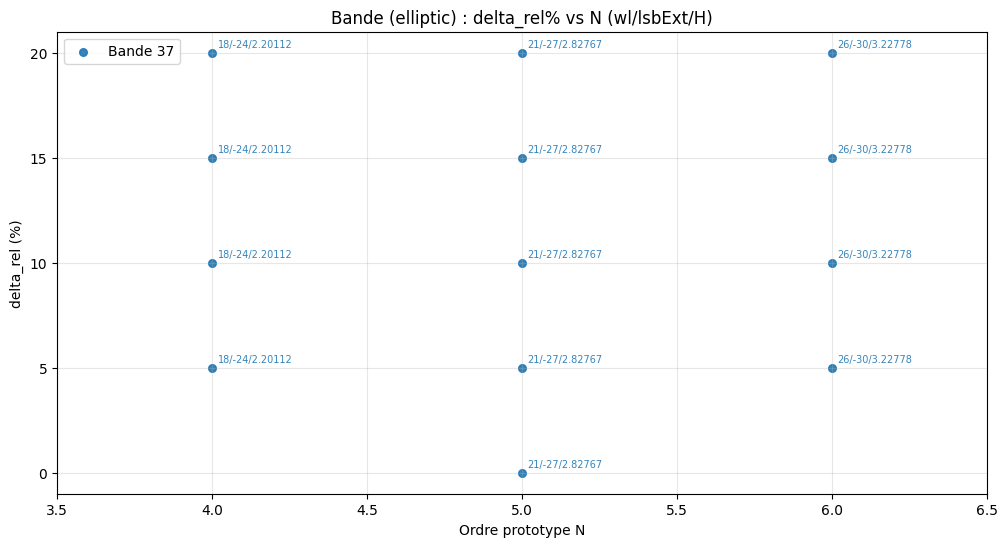

[FloPoCo] band=38 N=4 d=0.05 try quantized wl=16
  quantized coeffb hex: 0x1.4000000000000p-9:0x1.4000000000000p-10:0x1.2000000000000p-9:0x1.8000000000000p-10:0x1.1000000000000p-8:0x1.8000000000000p-10:0x1.2000000000000p-9:0x1.4000000000000p-10:0x1.4000000000000p-9
  quantized coeffa hex: 0x1.9080000000000p-1:0x1.dcd8000000000p+1:0x1.0e38000000000p+1:0x1.4918000000000p+2:0x1.edb0000000000p+0:0x1.8e50000000000p+1:0x1.3080000000000p-1:0x1.63a0000000000p-1
[FloPoCo] band=38 N=4 d=0.1 try quantized wl=16
  quantized coeffb hex: 0x1.4000000000000p-9:0x1.4000000000000p-10:0x1.2000000000000p-9:0x1.8000000000000p-10:0x1.1000000000000p-8:0x1.8000000000000p-10:0x1.2000000000000p-9:0x1.4000000000000p-10:0x1.4000000000000p-9
  quantized coeffa hex: 0x1.9080000000000p-1:0x1.dcd8000000000p+1:0x1.0e38000000000p+1:0x1.4918000000000p+2:0x1.edb0000000000p+0:0x1.8e50000000000p+1:0x1.3080000000000p-1:0x1.63a0000000000p-1
[FloPoCo] band=38 N=4 d=0.15 try quantized wl=16
  quantized coeffb hex: 0x1.40000000

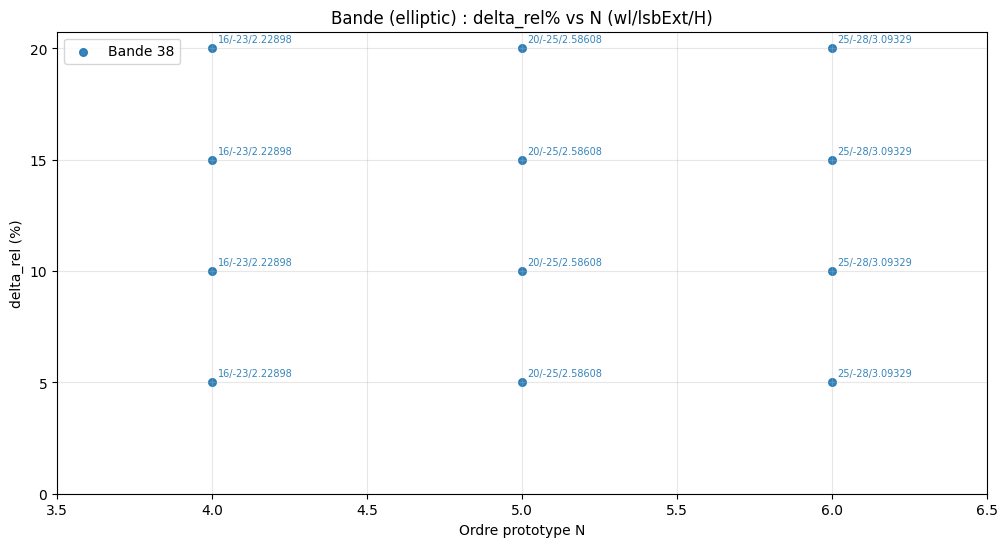

[FloPoCo] band=39 N=4 d=0.05 try quantized wl=18
  quantized coeffb hex: 0x1.d000000000000p-9:0x1.f000000000000p-8:0x1.e000000000000p-8:0x1.1800000000000p-7:0x1.6c00000000000p-7:0x1.1800000000000p-7:0x1.e000000000000p-8:0x1.f000000000000p-8:0x1.d000000000000p-9
  quantized coeffa hex: 0x1.ee54000000000p+1:0x1.1f39000000000p+3:0x1.b245000000000p+3:0x1.e3e1000000000p+3:0x1.8351000000000p+3:0x1.c8ce000000000p+2:0x1.5de8000000000p+1:0x1.4390000000000p-1
[FloPoCo] band=39 N=4 d=0.1 try quantized wl=17
  quantized coeffb hex: 0x1.e000000000000p-9:0x1.f000000000000p-8:0x1.e000000000000p-8:0x1.1800000000000p-7:0x1.7000000000000p-7:0x1.1800000000000p-7:0x1.e000000000000p-8:0x1.f000000000000p-8:0x1.e000000000000p-9
  quantized coeffa hex: 0x1.ee58000000000p+1:0x1.1f38000000000p+3:0x1.b244000000000p+3:0x1.e3e2000000000p+3:0x1.8352000000000p+3:0x1.c8d0000000000p+2:0x1.5de8000000000p+1:0x1.43a0000000000p-1
[FloPoCo] band=39 N=4 d=0.15 try quantized wl=16
  quantized coeffb hex: 0x1.c000000000000p-9

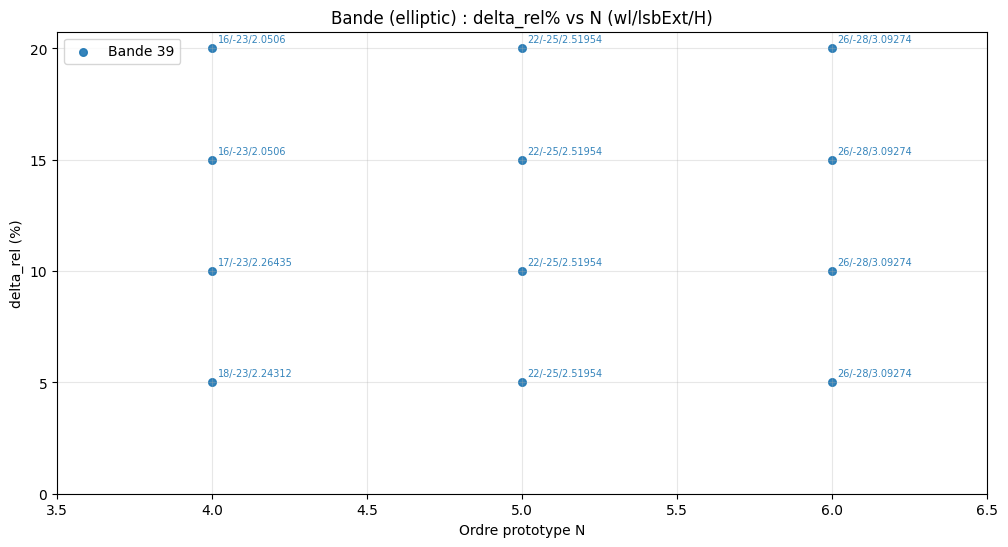

Ranges: {39: (4, 6)}
Nb points valides: 12


In [25]:
for i in range(37, 40):
    ranges_1, points_1 = plot_elliptic_simulation(
        bands_to_plot=(i,),
        fs=fs,
        delta_list=(0.00, 0.05, 0.10, 0.15, 0.20),
        ripple_db=ripple_db,
        att_db=att_db,
        wl_max=53,
        use_ord_Wn=True,
        N_search_max=60,
        title="Bande (elliptic) : delta_rel% vs N (wl/lsbExt/H)",
    )
print("Ranges:", ranges_1)
print("Nb points valides:", len(points_1))

Bande 24, N=4, delta_rel=0.05
fl = 222.72 Hz, f0 = 250.00 Hz, fu = 280.62 Hz
Flottant: stable=True, max|p|=0.999273
ANSI (flottant): {'ripple_pp_db': 1.9296228984055523, 'att_stop_db': 59.17722822021087, 'stable': True, 'valid': True, 'spec_ripple_pp_max_db': 2.1, 'spec_att_min_db': 57.0}
Quantifié minimal trouvé : wl=52 (integer_bits=8, frac_bits=44)
Quantifié: stable=True, max|p|=0.999078
ANSI (quantifié): {'ripple_pp_db': 1.7695094158210893, 'att_stop_db': 59.01727494257849, 'stable': True, 'valid': True, 'spec_ripple_pp_max_db': 2.1, 'spec_att_min_db': 57.0}


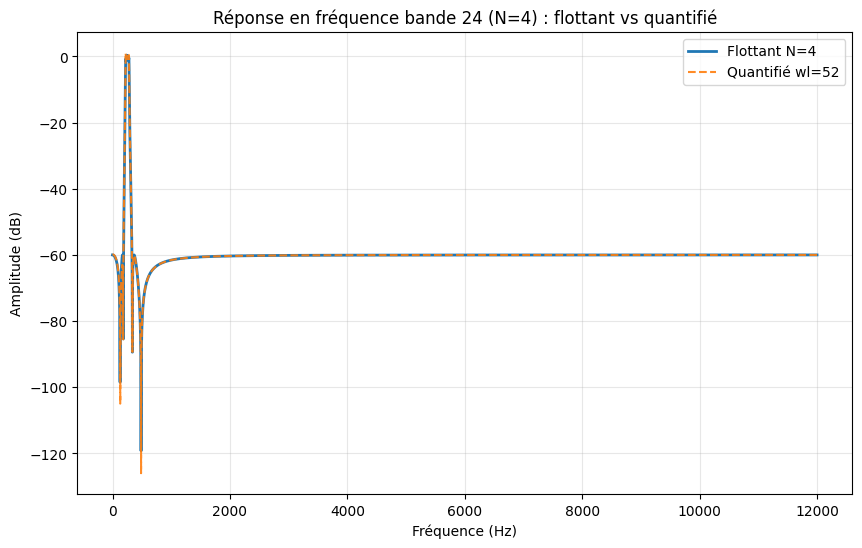

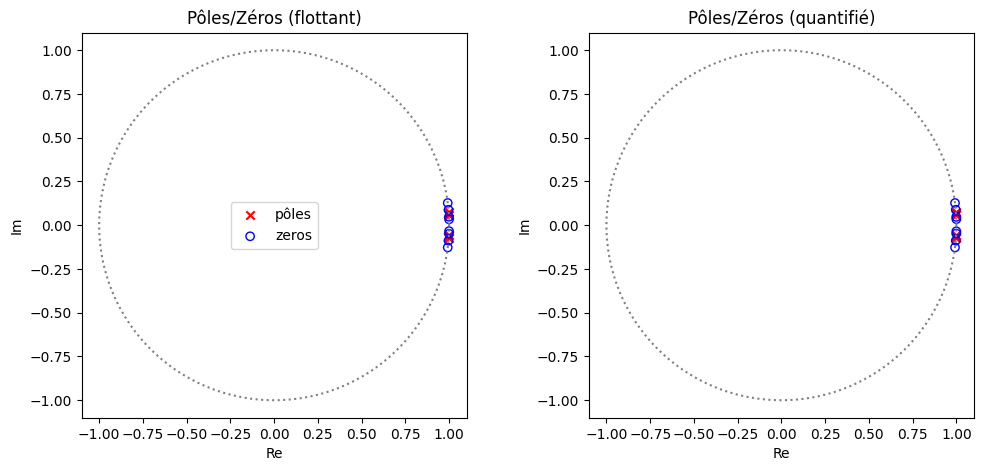

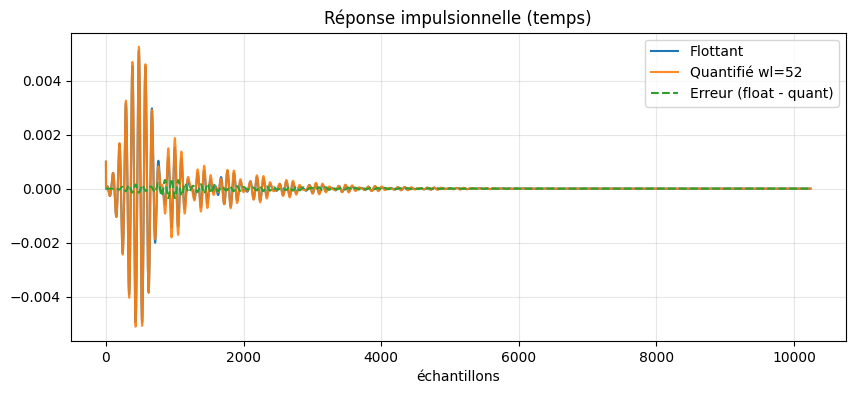


Valeurs quantifiées (float) :
b (quantized float): [0.00099536820243884, -0.007935573484530778, 0.027706288735259932, -0.055330884318152584, 0.06912960173031024, -0.055330884318152584, 0.027706288735259932, -0.007935573484530778, 0.00099536820243884]
a (quantized float): [1.0, -7.968298973910521, 27.795825947248602, -55.44026516463583, 69.15451577223274, -55.24146454423112, 27.596840212962945, -7.882886922646662, 0.985733673313689]

Float hex (coeff quantifiés) :
b hex : ['0x1.04ee078200000p-10', '-0x1.04086a4ba8000p-7', '0x1.c5f09900bc000p-6', '-0x1.c54546535e000p-5', '0x1.1b27a429e0000p-4', '-0x1.c54546535e000p-5', '0x1.c5f09900bc000p-6', '-0x1.04086a4ba8000p-7', '0x1.04ee078200000p-10']
a hex : ['0x1.0000000000000p+0', '-0x1.fdf89c426c8c0p+2', '0x1.bcbbb3fd0bdb0p+4', '-0x1.bb85a9be1d6e8p+5', '0x1.149e3961f1d2cp+6', '-0x1.b9ee84f684ee0p+5', '0x1.b98ca852b9d10p+4', '-0x1.f8813826b5580p+2', '0x1.f8b21582e5800p-1']

Terminé.


In [26]:
band = 24
N = 4  
delta_rel_test = 0.05

print(f"Bande {band}, N={N}, delta_rel={delta_rel_test}")

# --- Fréquences de la bande ---
fl, f0, fu = ansi_band(band)
print(f"fl = {fl:.2f} Hz, f0 = {f0:.2f} Hz, fu = {fu:.2f} Hz")

# --- Design floating-point ---
b_f, a_f = design_elliptic_bandpass(fl, fu, fs, N=N, ripple_db=ripple_db, att_db=att_db, use_ord_Wn=True)

poles_f, max_abs_pole_f, stable_f = check_iir_stability_ba(a_f)
print(f"Flottant: stable={stable_f}, max|p|={max_abs_pole_f:.6f}")
res_f = verify_ansi_standard(b_f, fl, fu, fs, delta_rel=delta_rel_test, a=a_f, ripple_db=ripple_db, att_db=att_db)
print("ANSI (flottant):", res_f)

# --- Recherche minimal WL qui passe ---
out = find_min_word_length_for_valid_elliptic(fl, fu, fs, N=N, delta_rel=delta_rel_test, ripple_db=ripple_db, att_db=att_db, wl_max=53, use_ord_Wn=True)
if out is None:
    print("Aucun WL <= 53 ne passe pour ces specs (N, delta_rel). On peut augmenter wl_max si souhaité.")
    wl_min = None
    b_q = a_q = None
else:
    wl_min, integer_bits, frac_bits = out
    b_q, a_q, _ = quantize_iir_ba(b_f, a_f, wl=wl_min, integer_bits=integer_bits, wrap=False)
    poles_q, max_abs_pole_q, stable_q = check_iir_stability_ba(a_q)
    res_q = verify_ansi_standard(b_q, fl, fu, fs, delta_rel=delta_rel_test, a=a_q, ripple_db=ripple_db, att_db=att_db)
    print(f"Quantifié minimal trouvé : wl={wl_min} (integer_bits={integer_bits}, frac_bits={frac_bits})")
    print(f"Quantifié: stable={stable_q}, max|p|={max_abs_pole_q:.6f}")
    print("ANSI (quantifié):", res_q)

# --- Tracé réponses en fréquence ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
w, Hf = freqz(b_f, a_f, worN=8192, fs=fs)
ax.plot(w, 20 * np.log10(np.maximum(np.abs(Hf), 1e-12)), label=f"Flottant N={N}", lw=2)
if out is not None:
    w, Hq = freqz(b_q, a_q, worN=8192, fs=fs)
    ax.plot(w, 20 * np.log10(np.maximum(np.abs(Hq), 1e-12)), linestyle='--', label=f"Quantifié wl={wl_min}", lw=1.5, alpha=0.9)
# Marqueurs des bornes
ax.set_xlabel('Fréquence (Hz)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title(f"Réponse en fréquence bande {band} (N={N}) : flottant vs quantifié")
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.show()

# --- Diagramme pôles/zéros ---
fig, axes = plt.subplots(1, 2 if out is not None else 1, figsize=(12, 5))
if out is not None:
    ax1, ax2 = axes
else:
    ax1 = axes

z_f, p_f, k_f = tf2zpk(b_f, a_f)
ax1.scatter(np.real(p_f), np.imag(p_f), marker='x', color='r', label='pôles'), ax1.scatter(np.real(z_f), np.imag(z_f), marker='o', facecolors='none', edgecolors='b', label='zeros')
ax1.set_title('Pôles/Zéros (flottant)')
ax1.set_xlabel('Re'), ax1.set_ylabel('Im')
# unit circle
theta = np.linspace(0, 2*np.pi, 201)
ax1.plot(np.cos(theta), np.sin(theta), ':', color='gray')
ax1.set_aspect('equal', 'box')
ax1.legend()

if out is not None:
    z_q, p_q, k_q = tf2zpk(b_q, a_q)
    ax2.scatter(np.real(p_q), np.imag(p_q), marker='x', color='r'), ax2.scatter(np.real(z_q), np.imag(z_q), marker='o', facecolors='none', edgecolors='b')
    ax2.set_title('Pôles/Zéros (quantifié)')
    ax2.set_xlabel('Re'), ax2.set_ylabel('Im')
    ax2.plot(np.cos(theta), np.sin(theta), ':', color='gray')
    ax2.set_aspect('equal', 'box')

plt.show()

# --- Réponse impulsionnelle et erreur temporelle ---
imp_len = 1024
imp = np.zeros(imp_len); imp[0] = 1.0
h_float = lfilter(b_f, a_f, imp)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(h_float, label='Flottant')
if out is not None:
    h_quant = lfilter(b_q, a_q, imp)
    ax.plot(h_quant, label=f'Quantifié wl={wl_min}', alpha=0.9)
    ax.plot(h_float - h_quant, label='Erreur (float - quant)', linestyle='--')
ax.set_title('Réponse impulsionnelle (temps)')
ax.set_xlabel('échantillons')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# --- Résumé / Coefficients quantifiés (binaire) ---
if out is not None:
    scale = 2 ** frac_bits
    fixed_b = (np.round(b_q * scale)).astype(int)
    fixed_a = (np.round(a_q * scale)).astype(int)

    # Vraies valeurs quantifiées (float) : les coefficients après quantification
    print('\nValeurs quantifiées (float) :')
    print('b (quantized float):', [float(x) for x in b_q])
    print('a (quantized float):', [float(x) for x in a_q])

    # Représentation hex de ces floats (utile pour vérification rapide)
    print('\nFloat hex (coeff quantifiés) :')
    print('b hex :', [c.hex() for c in b_q])
    print('a hex :', [c.hex() for c in a_q])


In [24]:
def q_msb_lsb(x, msb, lsb, wrap=False):
    """
    Quantifie x en utilisant une description de format type FloPoCo (msb/lsb).

    - msb : indice du bit de poids fort (incluant le bit de signe)
    - lsb : indice du bit de poids faible (souvent négatif)

    Exemple : msb=0, lsb=-12  -> wl = 13 bits, ib = 1  -> Q1.12
    """
    wl = msb - lsb + 1       # longueur totale
    ib = msb + 1             # nb de bits entiers incluant le signe
    return quantize(x, wl, integer_bits=ib, wrap=wrap)


In [25]:
class IIR_DFI_Float:
    def __init__(self, b, a):
        self.b = np.asarray(b, float)
        self.a = np.asarray(a, float)

        self.nb = len(self.b)
        self.na = len(self.a) - 1

        self.u_buf = np.zeros(self.nb)
        self.y_buf = np.zeros(self.na)

    def step(self, u):
        # buffer entrée
        if self.nb > 1:
            self.u_buf[1:] = self.u_buf[:-1]
        self.u_buf[0] = u

        # feedforward
        acc_ff = float(np.sum(self.b * self.u_buf))

        # feedback (a0=1)
        acc_fb = 0.0
        if self.na > 0:
            acc_fb = float(np.sum(self.a[1:] * self.y_buf))

        y = acc_ff - acc_fb

        # maj buffer feedback
        if self.na > 1:
            self.y_buf[1:] = self.y_buf[:-1]
        if self.na > 0:
            self.y_buf[0] = y

        return y


In [26]:
class IIR_DFI_Fixed:
    def __init__(
        self,
        b, a,
        fmt_in: Tuple[int,int],
        fmt_bmul: Tuple[int,int],
        fmt_amul: Tuple[int,int],
        fmt_ext: Tuple[int,int],
        fmt_out: Tuple[int,int],
        wrap: bool = False
    ):
        self.b = np.asarray(b, float)
        self.a = np.asarray(a, float)

        self.nb = len(self.b)
        self.na = len(self.a) - 1

        self.u_buf = np.zeros(self.nb)
        self.y_buf = np.zeros(self.na)

        self.msb_in, self.lsb_in = fmt_in
        self.msb_bmul, self.lsb_b = fmt_bmul
        self.msb_amul, self.lsb_a = fmt_amul
        self.msb_ext, self.lsb_ext = fmt_ext
        self.msb_out, self.lsb_out = fmt_out

        self.wrap = wrap

    def step(self, u):
        # (1) quantif entrée
        u_q = q_msb_lsb(u, self.msb_in, self.lsb_in, wrap=self.wrap)

        # buffer entrée
        if self.nb > 1:
            self.u_buf[1:] = self.u_buf[:-1]
        self.u_buf[0] = u_q

        # (2) multiplications feedforward quantifiées sur lsb_b
        acc_ff = 0.0
        for i in range(self.nb):
            p = self.b[i] * self.u_buf[i]
            p = q_msb_lsb(p, self.msb_bmul, self.lsb_b, wrap=self.wrap)
            acc_ff += p

        # (2) multiplications feedback quantifiées sur lsb_a
        acc_fb = 0.0
        for i in range(self.na):
            p = self.a[i+1] * self.y_buf[i]
            p = q_msb_lsb(p, self.msb_amul, self.lsb_a, wrap=self.wrap)
            acc_fb += p

        # (3) somme interne avant récursion (lsb_ext)
        s = acc_ff - acc_fb
        y_tilde = q_msb_lsb(s, self.msb_ext, self.lsb_ext, wrap=self.wrap)

        # maj buffer feedback avec y_tilde (c’est ça qui tourne dans la boucle)
        if self.na > 1:
            self.y_buf[1:] = self.y_buf[:-1]
        if self.na > 0:
            self.y_buf[0] = y_tilde

        # (4) sortie quantifiée
        y_out = q_msb_lsb(y_tilde, self.msb_out, self.lsb_out, wrap=self.wrap)
        return y_out


In [27]:
@dataclass
class MultirateFilterBank:
    # octaves[k] = liste de filtres (chaque filtre = un objet avec .step(u))
    octaves: List[List[object]]

    def n_octaves(self):
        return len(self.octaves)

    def n_filters_octave(self, k):
        return len(self.octaves[k])


In [28]:
def etatCourant_all(n: int, n_octaves: int) -> List[int]:
    """
    Renvoie la liste des octaves qui doivent traiter l'échantillon x[n]
    (décimation implicite : octave k active si n multiple de 2^k).
    """
    active = []
    for k in range(n_octaves):
        if n % (2**k) == 0:
            active.append(k)
    return active


def etatCourant_one_per_cycle(n: int, n_octaves: int):
    """
    Variante "1 octave par cycle" : renvoie une séquence d'octaves à traiter
    pour l'échantillon n. Exemple:
      n=0 -> [0,1,2,3]
      n=1 -> [0]
      n=2 -> [0,1]
    """
    return etatCourant_all(n, n_octaves)


In [29]:
def simulate_multirate(
    x: np.ndarray,
    fb: MultirateFilterBank
):
    """
    Simule le système multirate.

    Pour chaque échantillon x[n], on active les octaves k telles que n % 2^k == 0,
    et on pousse x[n] dans tous les filtres de l’octave k.

    Retour:
      outputs[k] = np.array de shape (Nk, n_filters_octave(k))
    """
    x = np.asarray(x, float)
    n_oct = fb.n_octaves()

    outputs = [ [] for _ in range(n_oct) ]

    for n in range(len(x)):
        for k in etatCourant_all(n, n_oct):
            u = x[n]
            yk = [f.step(u) for f in fb.octaves[k]]
            outputs[k].append(yk)

    # listes -> arrays
    for k in range(n_oct):
        outputs[k] = np.array(outputs[k], float) if len(outputs[k]) else np.zeros((0, fb.n_filters_octave(k)))

    return outputs


In [30]:
def upsample_hold(y_oct: np.ndarray, factor: int, target_len: int):
    """
    y_oct: (Nk, M)
    factor: 2^k
    -> renvoie (target_len, M) en répétant chaque échantillon 'factor' fois.
    """
    if y_oct.shape[0] == 0:
        return np.zeros((target_len, y_oct.shape[1]))

    y_rep = np.repeat(y_oct, repeats=factor, axis=0)
    if y_rep.shape[0] < target_len:
        pad = target_len - y_rep.shape[0]
        y_rep = np.vstack([y_rep, np.zeros((pad, y_rep.shape[1]))])
    else:
        y_rep = y_rep[:target_len]
    return y_rep


def build_spectrogram_matrix(outputs, n_octaves: int, base_len: int):
    """
    outputs[k] = (Nk, M_k) à fs/2^k
    -> matrice (sum_k M_k, base_len) alignée au temps base
    """
    bands_time = []
    for k in range(n_octaves):
        factor = 2**k
        yk = outputs[k]                     # (Nk, M_k)
        yk_up = upsample_hold(yk, factor, base_len)  # (base_len, M_k)
        bands_time.append(yk_up.T)          # (M_k, base_len)
    return np.vstack(bands_time)           # (nb_bandes_total, base_len)


def plot_spectrogram_db(S, fs, title, eps=1e-12):
    """
    S: (nb_bandes, N) amplitude/valeurs temps
    affichage en dB (20log10)
    """
    SdB = 20*np.log10(np.maximum(np.abs(S), eps))

    plt.figure(figsize=(12, 6))
    plt.imshow(
        SdB,
        aspect='auto',
        origin='lower',
        extent=[0, len(SdB[0])/fs, 0, SdB.shape[0]],
    )
    plt.colorbar(label="dB")
    plt.xlabel("temps (s)")
    plt.ylabel("index bande (toutes octaves empilées)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


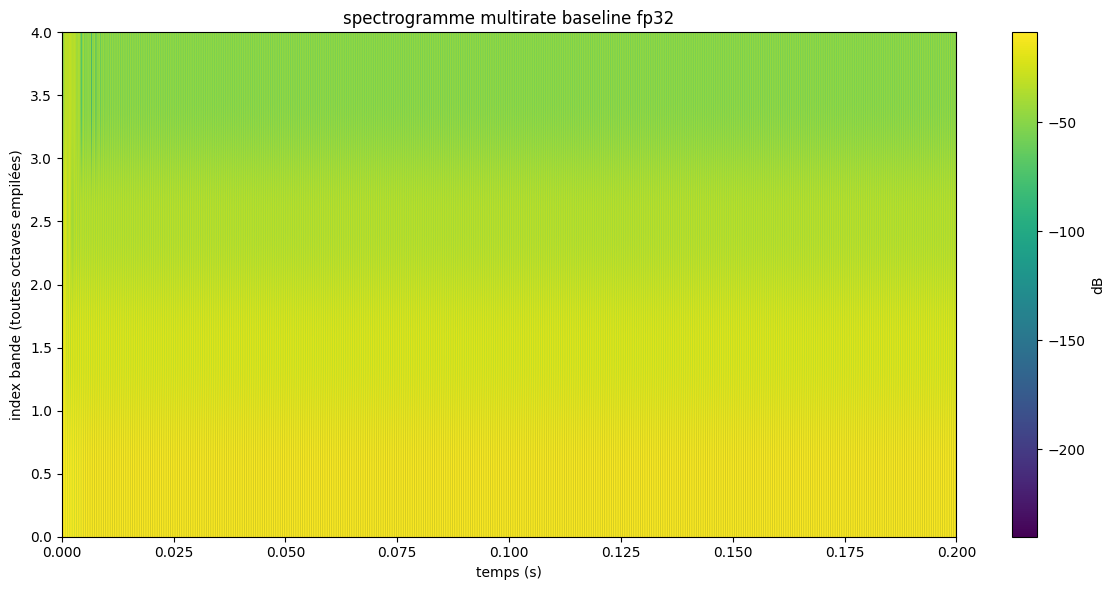

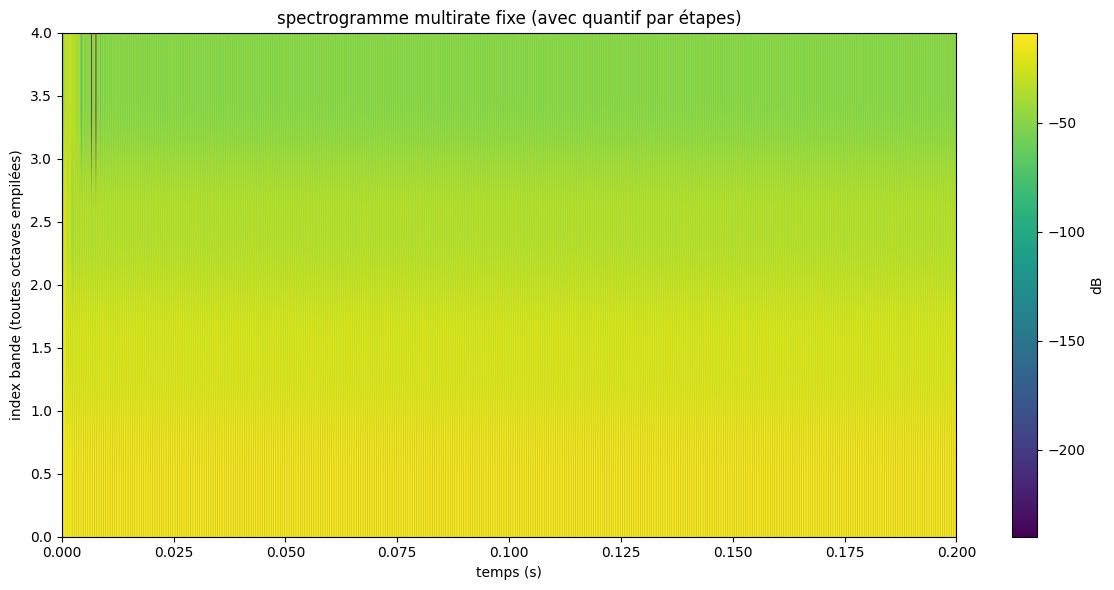

octave 0 shape (9600, 1) min -0.358642578125 max 0.363525390625 rms 0.24993188590744453
octave 1 shape (4800, 1) min -0.123046875 max 0.20849609375 rms 0.0852560874744411
octave 2 shape (2400, 1) min -0.03173828125 max 0.088623046875 rms 0.021572095790578446
octave 3 shape (1200, 1) min -0.007080078125 max 0.03173828125 rms 0.005305519941331367


In [31]:
from scipy.signal import butter

fs = 48000
duration = 0.2
t = np.linspace(0, duration, int(fs*duration), endpoint=False)
x = 0.5*np.sin(2*np.pi*1000*t)

# 1 filtre par octave (demo)
octaves_float = []
octaves_fixed = []

# formats fixes (exemple)
fmt_in   = (1,  -12)   # msb_in, lsb_in
fmt_bmul = (3,  -24)   # produits b*u
fmt_amul = (3,  -24)   # produits a*y
fmt_ext  = (4,  -30)   # lsbExt (bits de garde)
fmt_out  = (1,  -12)   # sortie

for k in range(4):
    fs_k = fs // (2**k)
    fc = 1000 / (2**k)
    b, a = butter(2, fc/(fs_k/2), btype='low', output='ba')

    # float
    octaves_float.append([IIR_DFI_Float(b, a)])
    # fixed
    octaves_fixed.append([IIR_DFI_Fixed(b, a, fmt_in, fmt_bmul, fmt_amul, fmt_ext, fmt_out)])

# baseline fp32
fb_fp = MultirateFilterBank(octaves=octaves_float)
out_fp = simulate_multirate(x, fb_fp)
S_fp = build_spectrogram_matrix(out_fp, n_octaves=4, base_len=len(x))
plot_spectrogram_db(S_fp, fs, "spectrogramme multirate baseline fp32")

# fixe
fb_fx = MultirateFilterBank(octaves=octaves_fixed)
out_fx = simulate_multirate(x, fb_fx)
S_fx = build_spectrogram_matrix(out_fx, n_octaves=4, base_len=len(x))
plot_spectrogram_db(S_fx, fs, "spectrogramme multirate fixe (avec quantif par étapes)")

# Debug rapide : stats des sorties fixe
for k in range(4):
    yk = out_fx[k]
    print("octave", k, "shape", yk.shape,
          "min", np.min(yk) if yk.size else None,
          "max", np.max(yk) if yk.size else None,
          "rms", np.sqrt(np.mean(yk**2)) if yk.size else None)



In [32]:
def compute_error_metrics(out_fp, out_fx):
    """
    Calcule les métriques d'erreur entre sorties float et fixe
    pour chaque octave.
    """
    metrics = []

    for k in range(len(out_fp)):
        y_fp = np.asarray(out_fp[k]).squeeze()
        y_fx = np.asarray(out_fx[k]).squeeze()

        # Alignement sécurité
        N = min(len(y_fp), len(y_fx))
        y_fp = y_fp[:N]
        y_fx = y_fx[:N]

        err = y_fx - y_fp

        rms_fp = np.sqrt(np.mean(y_fp**2))
        rms_fx = np.sqrt(np.mean(y_fx**2))
        rms_err = np.sqrt(np.mean(err**2))

        err_db = 20 * np.log10(rms_err / rms_fp + 1e-15)

        metrics.append({
            "octave": k,
            "rms_fp": rms_fp,
            "rms_fx": rms_fx,
            "rms_err": rms_err,
            "err_db": err_db
        })

    return metrics


In [33]:
metrics = compute_error_metrics(out_fp, out_fx)

for m in metrics:
    print(
        f"Octave {m['octave']} | "
        f"RMS FP = {m['rms_fp']:.4e} | "
        f"RMS FX = {m['rms_fx']:.4e} | "
        f"RMS err = {m['rms_err']:.4e} | "
        f"Erreur = {m['err_db']:.2f} dB"
    )


Octave 0 | RMS FP = 2.4992e-01 | RMS FX = 2.4993e-01 | RMS err = 4.4447e-05 | Erreur = -75.00 dB
Octave 1 | RMS FP = 8.5269e-02 | RMS FX = 8.5256e-02 | RMS err = 7.4497e-05 | Erreur = -61.17 dB
Octave 2 | RMS FP = 2.1549e-02 | RMS FX = 2.1572e-02 | RMS err = 6.5747e-05 | Erreur = -50.31 dB
Octave 3 | RMS FP = 5.3111e-03 | RMS FX = 5.3055e-03 | RMS err = 8.3063e-05 | Erreur = -36.12 dB


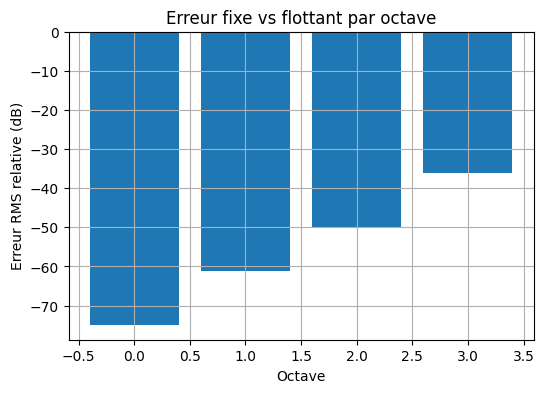

In [34]:
octaves = [m["octave"] for m in metrics]
err_db = [m["err_db"] for m in metrics]

plt.figure(figsize=(6,4))
plt.bar(octaves, err_db)
plt.xlabel("Octave")
plt.ylabel("Erreur RMS relative (dB)")
plt.title("Erreur fixe vs flottant par octave")
plt.grid(True)
plt.show()
